In [2]:
#imports tools and constants definitions
import numpy as np
from astropy.io import ascii 
import matplotlib.pyplot as plt 
from matplotlib import cm
import pandas as pd
%matplotlib inline

In [3]:
#reads the data and tests for correct input
data = ascii.read('Astr511HW1data.dat.txt',format='commented_header') #commented_head use this in jupyter notebooks
print(data[:10])
 ##    ra        dec   run     Ar      u      g      r      i      z  uErr  gErr  rErr  iErr  zErr    pmL    pmB    pmErr

    ra      dec    run   Ar    u     g   ... rErr iErr zErr  pmL   pmB   pmErr
--------- -------- ---- ---- ----- ----- ... ---- ---- ---- ----- ------ -----
 181.6122  27.5726 5087 0.05  16.4 15.24 ... 0.02 0.02 0.01  5.16  -1.45  2.72
181.61303  27.6077 5087 0.05 21.84 19.55 ... 0.02 0.02 0.02  5.48   4.73  3.16
181.61416 27.35956 5112 0.05 19.76 17.56 ... 0.02 0.03 0.03  3.14   7.92  2.79
 181.6164 27.82464 5112 0.06 21.73 20.63 ... 0.03 0.03 0.13 19.13  -1.08  5.08
181.62112 28.01623 5087 0.05 21.37 20.38 ... 0.03 0.03 0.09 -3.65   -8.0  4.91
181.62252 27.63987 5087 0.05 17.34 15.58 ... 0.02 0.02 0.01  9.74 -10.64  2.72
181.62469 27.32682 5112 0.05 21.63 20.52 ... 0.03 0.04 1.07  6.73 -25.39  5.13
181.62582 27.42162 5112 0.05 23.16 21.09 ... 0.02 0.03 0.04 35.17    7.8  4.18
181.63178 26.93836 5112 0.05 18.57 15.96 ... 0.02 0.02 0.02 15.96  -8.01  2.72
181.63364 27.24131 5087 0.06  20.9 18.78 ... 0.02 0.02 0.02  2.03  -5.43  2.96


In [4]:
#computes metallicity function [Bond et al. 2010]
def metallicity(x,y):
    """
    Calculates metallicity [Bond et al. 2010]
        
            Parameters:
                x( float array): u-g SDSS band
                y( float array): g-r SDSS band
            Returns:
                metallicity (float array): Fe/H
    """
    #defines best-fit coefficients given by Bond et al. in array type from A-J
    A=-13.13
    B= 14.09
    C= 28.04
    D= -5.51
    E= -5.90
    F= -58.68
    G= 9.14
    H= -20.61
    I= 0.0
    J= 58.20
    #creates empty array to allocate results 
    metallicityArray = np.empty(y.size)
    metallicityArray[:] = 0
    #loops through  data 
    for i in range (y.size):
        if(y[i] < 0.6 ):    
        #appends to resulting metallicity array and computes the formula. This seems very tricky but it's simple don't panick h
            metallicityArray[i] = A+B*x[i]+C*y[i]+D*x[i]*y[i]+E*(x[i]**2)+F*(y[i]**2)+G*((x[i])**2)*y[i]+H*x[i]*((y[i])**2)+I*((x[i])**3)+J*(y[i]**3)
        else:
            metallicityArray[i] = -0.6
    return metallicityArray
    # metallicityArray[i] = A + B*x[i]+ C*y[i] + D*x[i]*y[i] + E*pow(x,2) + F*pow(y,2)+G*pow(x,2)*y + H*pow(y,2)*x + I*pow(x,3)+J*pow(y,3)


In [5]:
#tests metallicity function
x = np.array(data['u'] - data['g'])
y = np.array(data['g'] - data['r'])
FeH = metallicity(x,y)
print(FeH)

[-0.8191296 -0.6       -0.6       ... -0.6       -0.6       -0.6      ]


In [6]:
#computes absolute magnitude using photometric parallax relationship [Ivezić et al. 2008]
def abs_mag(band):
    """
    Calculates absolute magnitudes [Bond et al. 2010]
        
            Parameters:
                band( float array): g-i SDSS band
            Returns:
                absolute magnitudes(float array)
    """
    #defines an empty array to return result
    absolute_magnitude = np.empty(band.size)
    #computes metallicity with previous function
    metas = metallicity(x,y)
    #loops through the arrays
    for i in range(band.size):
        mgn_metallicity = 4.50 -1.11*metas[i] -0.18*pow(metas[i],2)
        #A7
        mgn_band = -5.06  +14.32*band[i] - 12.97*pow(band[i],2) + 6.127*pow(band[i],3) - 1.267*pow(band[i],4) + 0.0967*pow(band[i],5)
        #A4
        absolute_magnitude[i] = mgn_band + mgn_metallicity
    return absolute_magnitude

In [7]:
#test abs_mag function
z = np.array(data['g'] - data['i'])
mag = abs_mag(z)
print(mag[:50])

[4.88853564 7.35863457 6.99674651 5.64485961 3.93777605 6.21245575
 4.16177266 8.80018053 7.81967066 7.13325661 6.6090974  7.15312504
 9.00008196 5.87101687 5.19660953 5.58187673 6.30386407 7.67323561
 5.60238331 6.51519194 5.35027913 6.61439034 6.16487668 5.30720682
 3.19556732 4.52877622 6.21245575 3.63096175 7.19319385 8.13587644
 4.6269505  8.76762222 4.86438559 8.54593156 5.95950349 5.2726
 5.48947639 7.92153682 4.85531136 6.39095648 8.89916384 9.172468
 8.00023676 5.33635662 4.64081984 6.32601057 5.20893682 5.40817644
 6.67260076 5.29597751]


In [8]:
#computes distance using a function
def distance(absolutes,apparent):
    """
    Calculates distances in parsecs
        
            Parameters:
                Absolute: float array of absolute magnitude of a particular band
                Apparent: float array of apparent magnitude of a particular band
            Returns:
                distances in parsecs(float array)
    """
    #creates an empty array to return 
    formula = np.empty(absolutes.size)
    formula = (apparent - absolutes)/5
    result = np.power(10,formula)*10
    return result

In [9]:
#tests for distance(absolute,apparent) function
distanceParsec = distance(mag,np.array(data['r']))
print(distanceParsec)

[ 960.04783539 1615.37399051  836.85593009 ...  248.34974785  473.49750882
 1338.20802884]


In [10]:
#computes function to calculate volume
def volume_function(distance):
    #creates an empty array to return
    result = np.empty(distance.size)
    result[:] = 0
    for i in range(distance.size):
        result[i] = 4/3*np.pi*distance[i]**3
    return result
# volumes = 4/3*np.pi*distancesCool**3 [use for testing]

In [11]:
vol = volume_function(distanceParsec)
print(vol)

[3.70652751e+09 1.76566321e+10 2.45493899e+09 ... 6.41622787e+07
 4.44673967e+08 1.00382846e+10]


No handles with labels found to put in legend.


The number of stars within target range: 107673.000000 stars
The maximum distance is: 98928.784738 parsec
The minimum distance is: 577.277196 parsec


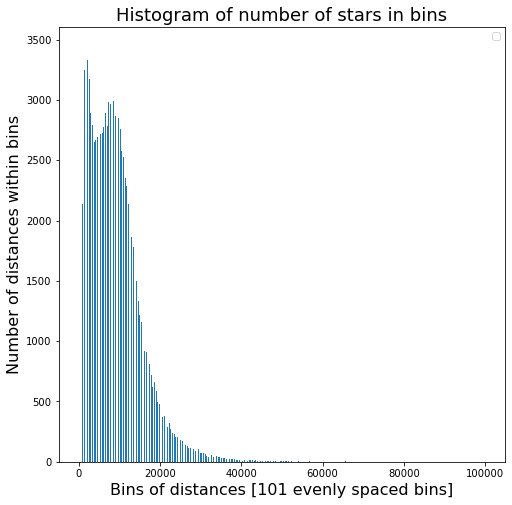

In [45]:
'Defines bin of volumes and plots distributions'
#counts number of interesting ojects
ctr = 0
for i in range(y.size):# `y` is the array containing g-r. There are more efficient ways to do this
    if y[i] < 0.4 and y[i] > 0.2:
        ctr += 1
#creates tuple array that matches conditions
is_target = np.empty(y.size)
for i in range(y.size):
    if (0.2 < y[i] and 0.4 > y[i]):
        is_target[i] = True
#extracts target values of g-r band using the previously created tupple array
target_bands = np.extract(is_target,y)
txt = "The number of stars within target range: {num:.6f} stars"
print(txt.format(num = target_bands.size))
#get distances of these values
target_distances = np.extract(is_target,distanceParsec)

txt1 = "The maximum distance is: {number1:.6f} parsec"
print(txt1.format(number1 = np.amax(target_distances)))
txt2 = "The minimum distance is: {number2:.6f} parsec"
print(txt2.format(number2 = np.amin(target_distances)))


#THREE: Plots distritbution of these stars 
bins=np.linspace(0,100000,250)
plt.figure(figsize=(8,8))
plt.hist(target_distances, bins, histtype='bar', rwidth=0.5)
plt.title('Histogram of number of stars in bins',fontsize =18)
plt.xlabel('Bins of distances [101 evenly spaced bins]', fontsize = 16)
plt.ylabel('Number of distances within bins',fontsize = 16)
plt.legend()
plt.show()

C:\Users\cosme\AppData\Local\Temp/ipykernel_6776/3360905405.py:26: RuntimeWarning: divide by zero encountered in log
  plt.plot(bins/1000,np.log(densitiesArrayTwo),'^',color = 'red')


(-23.0, -15.0)

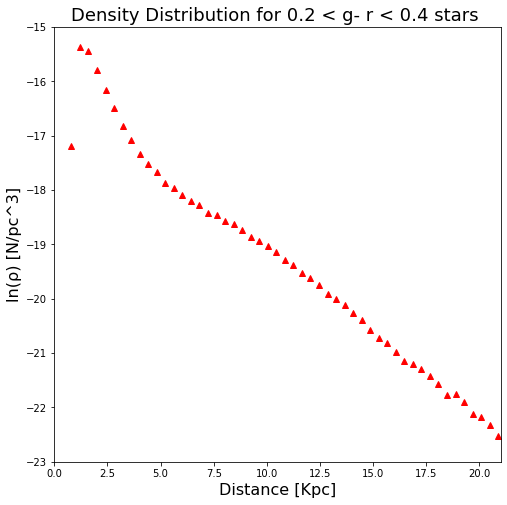

In [46]:
'Computes and plots the densities and distances. SORTED'
#writes a table with astropy with target_band and their respective distances
from astropy.table import Table
dat = Table()
dat['g-r'] = target_bands
dat['distance'] = target_distances
ascii.write(dat, 'values.dat', overwrite=True) 
dat = ascii.read('values.dat',format='basic') #commented_head use this in jupyter notebooks
#sorts table with respect to their distances from small to big.
dat.sort('distance')
#calculate their volumes
target_distanceTwo = np.array(dat['distance'])
target_volumesTwo = np.empty(bins.size)
for i in range(bins.size-1):
    target_volumesTwo[i]= 4/3*np.pi*pow(bins[i+1],3) - 4/3*np.pi*pow(bins[i],3)
#calulates number of stars 
target_ctrTwo = np.zeros(bins.size)
for i in range(1,bins.size):
    for j in range(target_distanceTwo.size):
        if (target_distanceTwo[j] <= bins[i] and target_distanceTwo[j] > bins[i-1]): #
            target_ctrTwo[i] += 1
#print(target_ctrTwo)
densitiesArrayTwo = target_ctrTwo/target_volumesTwo
#print(densitiesArrayTwo)
plt.figure(figsize=(8,8))
plt.plot(bins/1000,np.log(densitiesArrayTwo),'^',color = 'red')
plt.title('Density Distribution for 0.2 < g- r < 0.4 stars ', fontsize =18)
plt.xlabel('Distance [Kpc]',fontsize = 16)
plt.ylabel('ln(ρ) [N/pc^3]',fontsize = 16)
plt.xlim(0,21)
plt.ylim(-23,-15)

C:\Users\cosme\AppData\Local\Temp/ipykernel_6776/561825834.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(bins/1000,np.log(densitiesArrayTwo/np.amax(densitiesArrayTwo)),'^',color = 'red')


(-8.0, 2.0)

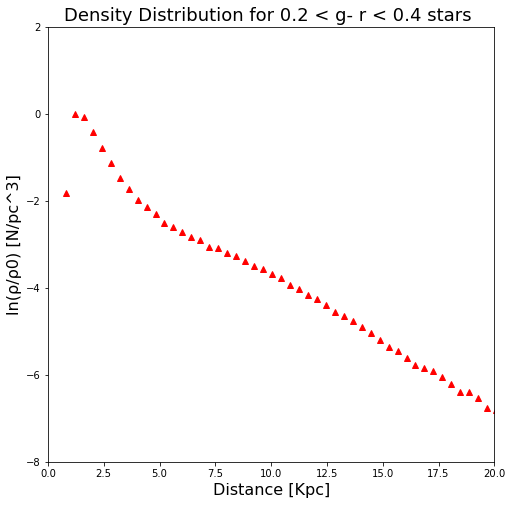

In [58]:
plt.figure(figsize=(8,8))
plt.plot(bins/1000,np.log(densitiesArrayTwo/np.amax(densitiesArrayTwo)),'^',color = 'red')
plt.title('Density Distribution for 0.2 < g- r < 0.4 stars ', fontsize =18)
plt.xlabel('Distance [Kpc]',fontsize = 16)
plt.ylabel('ln(ρ/ρ0) [N/pc^3]',fontsize = 16)
plt.xlim(0,20)
plt.ylim(-8,2)